<div style="border:solid green 2px; padding: 20px">
<b>Hello, Valentina!</b>

My name is Grigoriy Gusarov and I'm going to review your project.

My main goal is not to show that any mistakes have been made somewhere, but to share my experience that will help you in your further work. Further in the file you can see my comments, try to take them into account when performing the next tasks. **Please, don't delete them.**


You can find my comments in <font color='green'>green</font>, <font color='orange'>yellow</font> or <font color='red'>red</font> boxes like this:

<div class="alert alert-success">
<b>Reviewer's comment:</b> if everything is done succesfully
</div>

<div class="alert alert-warning">
<b>Reviewer's comment: </b> if I can give some recommendations
</div>

<div class="alert alert-danger">
<b>Reviewer's comment:</b> if the block requires some corrections. Work can't be accepted with the red comments.
</div>

    
Let's work on the project in dialogue: if you change something in the project or respond to my comments, write about it. It will be easier for me to track the changes if you highlight your comments:
    
<div class="alert alert-info"> <b>Student's comment:</b> For example like this.</div>

### <font color='orange'>General feedback</font>
Thank you for sending your project! In general - well done, I like your coding skills. Congratulations, your job has been accepted!

<div class="alert alert-warning">
<b>Reviewer's comment: </b> Additional links:
    <ul>
        <li>SHAP model explainer: <a>https://github.com/slundberg/shap</a></li>
        <li>Eli5 model explainer: <a>https://eli5.readthedocs.io/en/latest/</a></li>
        <li>Linear regression from scratch: <a>https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c</a></li>
        <li>TPOT - generic autoML assistant tool: <a>https://github.com/EpistasisLab/tpot/</a></li>
    </ul>
</div>

---

# project Description
Build a model that would predict the amount of gold recovered from gold ore for Zyfra using three datasets;
 * gold_recovery_train.csv 
 * gold_recovery_test.csv 
 * gold_recovery_full.csv

# Business Goal

1. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between the calculations and the feature values. Provide findings.
2. Analyze the features not available in the test set. What are these parameters? What is their type?
3. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
4. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
5. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
6. Write a function to calculate the final sMAPE value.
7. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.


<div class="alert alert-success">
<b>Reviewer's comment:</b> Nice plan, let's start üí™ 
</div>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as st 
from sklearn.dummy import DummyRegressor

In [2]:
def data_info(df):
    print('Head:')
    display(df)
    print('-END--')
    print('Info:')
    display(df.info())
    print('-END--')
    print('Percentage Null:')
    display(df.isnull().sum()/df.shape[0])
    print('-END--')
    print('Duplicated:')
    display(df.duplicated().sum())

def col_str(df, string):
    """This function takes the dataframe and sring being searched 
        for and returns all columns with the string."""
    cols = [col for col in df.columns if string in col]
    return df[cols]

def metal_contrate(df, metal, rougher, feed, stage):
    """ It takes five variable from the dataframe to results from string search,
        metal type etc and returns the sum of the columns. """
    rougher_df = col_str(gold_train,metal)
    rougher_df = col_str(rougher_df,rougher)
    rougher_df = col_str(rougher_df,feed)
    rougher_df = col_str(rougher_df,stage)
    total = rougher_df.sum()
    return total[0]

def smape(y_true, y_pred):
    """It takes the actual and predicted values and returns 
        the mean based on the descided formula"""
    frac = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(frac, axis=0)

def smape_final(y_true,y_pred):
    """It takes the actual and predicted values and returns 
        the sum based on the ratios of the two outputs."""
    smape_out_rougher = smape(y_true[target.index('rougher.output.recovery')], 
                              y_pred[target.index('rougher.output.recovery')])
    smape_out_final = smape(y_true[target.index('final.output.recovery')],
                            y_pred[target.index('final.output.recovery')])
    return 0.25*smape_out_rougher + 0.75*smape_out_final


def liner_reg(x_train, x_test,y_train, y_test):
    """Based on linearRegression, the function takes the datasets for training and 
        testing and returns the smape mean after scaling and training of the model."""
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    lr = LinearRegression().fit(x_train,y_train)
    predicted_values = lr.predict(x_test)
    smape = cross_val_score(lr, x_train,y_train,cv=5,scoring=smape_score)
    print('Mean smape:', smape.mean())
    print('Smape:', smape)
    

def DecisionTreeReg(x_train, x_test,y_train, y_test):
    """Based on Decision Tree, the function takes the features and target sets. 
        It searches and uses best parameters for the mean smape."""
    params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
    g_cv = GridSearchCV(DecisionTreeRegressor(random_state=123),
                        param_grid=params,scoring=smape_score, cv=5,refit=True)
    g_cv.fit(x_train, y_train)
    best_params = g_cv.best_params_
    dtr = DecisionTreeRegressor(**best_params).fit(x_train, y_train)
    scores_dtr = cross_val_score(dtr, x_train, y_train, cv=5, scoring=smape_score)
    print('Mean smape:', scores_dtr.mean())
    print('Accuracy:', g_cv.score(x_test,y_test))
    print('Smape:', scores_dtr) 
    print('Best params:',best_params)
    
def RandomForestReg(x_train, x_test,y_train, y_test):
    """Based on RandomForest, the function takes the features and target sets. 
        It searches and uses best parameters for the mean smape."""
    params = {'min_samples_split': range(2, 10, 2), 
              'max_depth': range(4,8,2), 'n_estimators':range(1,50,10)}
    g_cv = GridSearchCV(RandomForestRegressor(random_state=123),
                        param_grid=params,scoring=smape_score, cv=5,refit=True)
    g_cv.fit(x_train, y_train)
    best_params = g_cv.best_params_
    rtr = RandomForestRegressor(**best_params).fit(x_train, y_train)
    scores_dtr = cross_val_score(rtr, x_train, y_train, cv=5, scoring=smape_score)
    print('Mean smape:', scores_dtr.mean())
    print('Accuracy:', g_cv.score(x_test,y_test))
    print('Smape:', scores_dtr)
    print('Best params:',best_params)


<div class="alert alert-success">
<b>Reviewer's comment:</b> Great that you store all helper functions in a separate cell. 
</div>

In [3]:
try:
    gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
    gold_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')
except:
    gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
    gold_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv')

## Preprocessing

In [4]:
data_info(gold_train)

Head:


date  final.output.concentrate_ag  \
0      2016-01-15 00:00:00                     6.055403   
1      2016-01-15 01:00:00                     6.029369   
2      2016-01-15 02:00:00                     6.055926   
3      2016-01-15 03:00:00                     6.047977   
4      2016-01-15 04:00:00                     6.148599   
...                    ...                          ...   
16855  2018-08-18 06:59:59                     3.224920   
16856  2018-08-18 07:59:59                     3.195978   
16857  2018-08-18 08:59:59                     3.109998   
16858  2018-08-18 09:59:59                     3.367241   
16859  2018-08-18 10:59:59                     3.598375   

       final.output.concentrate_pb  final.output.concentrate_sol  \
0                         9.889648                      5.507324   
1                         9.968944                      5.257781   
2                        10.213995                      5.383759   
3                         9.977019                      4.858634   
4                        10.142511                      4.939416   
...                            ...                           ...   
16855                    11.356233                      6.803482   
16856                    11.349355                      6.862249   
16857                    11.434366                      6.886013   
16858                    11.625587                      6.799433   
16859                    11.737832                      6.717509   

       final.output.concentrate_au  final.output.recovery  \
0                        42.192020              70.541216   
1                        42.701629              69.266198   
2                        42.657501              68.116445   
3                        42.689819              68.347543   
4                        42.774141              66.927016   
...                            ...                    ...   
16855                    46.713954              73.755150   
16856                    46.866780              69.049291   
16857                    46.795691              67.002189   
16858                    46.408188              65.523246   
16859                    46.299438              70.281454   

       final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0                 10.411962              0.895447              16.904297   
1                 10.462676              0.927452              16.634514   
2                 10.507046              0.953716              16.208849   
3                 10.422762              0.883763              16.532835   
4                 10.360302              0.792826              16.525686   
...                     ...                   ...                    ...   
16855              8.769645              3.141541              10.403181   
16856              8.897321              3.130493              10.549470   
16857              8.529606              2.911418              11.115147   
16858              8.777171              2.819214              10.463847   
16859              8.406690              2.517518              10.652193   

       final.output.tail_au  ...  secondary_cleaner.state.floatbank4_a_air  \
0                  2.143149  ...                                 14.016835   
1                  2.224930  ...                                 13.992281   
2                  2.257889  ...                                 14.015015   
3                  2.146849  ...                                 14.036510   
4                  2.055292  ...                                 14.027298   
...                     ...  ...                                       ...   
16855              1.529220  ...                                 23.031497   
16856              1.612542  ...                                 22.960095   
16857              1.596616  ...                                 23.015718   
16858              1.602879  ...                                 23.02

-END--
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-n

None

-END--
Percentage Null:


date                                          0.000000
final.output.concentrate_ag                   0.004270
final.output.concentrate_pb                   0.004270
final.output.concentrate_sol                  0.021945
final.output.concentrate_au                   0.004211
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.005042
secondary_cleaner.state.floatbank5_b_air      0.005042
secondary_cleaner.state.floatbank5_b_level    0.004982
secondary_cleaner.state.floatbank6_a_air      0.006109
secondary_cleaner.state.floatbank6_a_level    0.005042
Length: 87, dtype: float64

-END--
Duplicated:


0

In [5]:
data_info(gold_test)

Head:


date  primary_cleaner.input.sulfate  \
0     2016-09-01 00:59:59                     210.800909   
1     2016-09-01 01:59:59                     215.392455   
2     2016-09-01 02:59:59                     215.259946   
3     2016-09-01 03:59:59                     215.336236   
4     2016-09-01 04:59:59                     199.099327   
...                   ...                            ...   
5851  2017-12-31 19:59:59                     173.957757   
5852  2017-12-31 20:59:59                     172.910270   
5853  2017-12-31 21:59:59                     171.135718   
5854  2017-12-31 22:59:59                     179.697158   
5855  2017-12-31 23:59:59                     181.556856   

      primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                            14.993118                         8.080000   
1                            14.987471                         8.080000   
2                            12.884934                         7.786667   
3                            12.006805                         7.640000   
4                            10.682530                         7.530000   
...                                ...                              ...   
5851                         15.963399                         8.070000   
5852                         16.002605                         8.070000   
5853                         15.993669                         8.070000   
5854                         15.438979                         8.070000   
5855                         14.995850                         8.070000   

      primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                           1.005021                             1398.981301   
1                           0.990469                             1398.777912   
2                           0.996043                             1398.493666   
3                           0.863514                             1399.618111   
4                           0.805575                             1401.268123   
...                              ...                                     ...   
5851                        0.896701                             1401.930554   
5852                        0.896519                             1447.075722   
5853                        1.165996                             1498.836182   
5854                        1.501068                             1498.466243   
5855                        1.623454                             1498.096303   

      primary_cleaner.state.floatbank8_a_level  \
0                                  -500.225577   
1                                  -500.057435   
2                                  -500.868360   
3                                  -498.863574   
4                                  -500.808305   
...                                        ...   
5851                               -499.728848   
5852                               -494.716823   
5853                               -501.770403   
5854                               -500.483984   
5855                               -499.796922   

      primary_cleaner.state.floatbank8_b_air  \
0                                1399.144926   
1                                1398.055362   
2                                1398.860436   
3                                1397.440120   
4                                1398.128818   
...                                      ...   
5851                             1401.441445   
5852                             1448.851892   
5853                             1499.572353   
5854                             1497.986986   
5855                             1501.743791   

      primary_cleaner.state.floatbank8_b_level  \
0                                  -499.919735   
1                                  -499.778182   
2                                  -499.764529   
3                                  -499.211024   
4         

-END--
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10 

None

-END--
Percentage Null:


date                                          0.000000
primary_cleaner.input.sulfate                 0.051571
primary_cleaner.input.depressant              0.048497
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.028347
primary_cleaner.state.floatbank8_a_air        0.002732
primary_cleaner.state.floatbank8_a_level      0.002732
primary_cleaner.state.floatbank8_b_air        0.002732
primary_cleaner.state.floatbank8_b_level      0.002732
primary_cleaner.state.floatbank8_c_air        0.002732
primary_cleaner.state.floatbank8_c_level      0.002732
primary_cleaner.state.floatbank8_d_air        0.002732
primary_cleaner.state.floatbank8_d_level      0.002732
rougher.input.feed_ag                         0.002732
rougher.input.feed_pb                         0.002732
rougher.input.feed_rate                       0.006831
rougher.input.feed_size                       0.003757
rougher.input.feed_sol                        0.011441
rougher.in

-END--
Duplicated:


0

In [6]:
data_info(gold_full)

Head:


date  final.output.concentrate_ag  \
0      2016-01-15 00:00:00                     6.055403   
1      2016-01-15 01:00:00                     6.029369   
2      2016-01-15 02:00:00                     6.055926   
3      2016-01-15 03:00:00                     6.047977   
4      2016-01-15 04:00:00                     6.148599   
...                    ...                          ...   
22711  2018-08-18 06:59:59                     3.224920   
22712  2018-08-18 07:59:59                     3.195978   
22713  2018-08-18 08:59:59                     3.109998   
22714  2018-08-18 09:59:59                     3.367241   
22715  2018-08-18 10:59:59                     3.598375   

       final.output.concentrate_pb  final.output.concentrate_sol  \
0                         9.889648                      5.507324   
1                         9.968944                      5.257781   
2                        10.213995                      5.383759   
3                         9.977019                      4.858634   
4                        10.142511                      4.939416   
...                            ...                           ...   
22711                    11.356233                      6.803482   
22712                    11.349355                      6.862249   
22713                    11.434366                      6.886013   
22714                    11.625587                      6.799433   
22715                    11.737832                      6.717509   

       final.output.concentrate_au  final.output.recovery  \
0                        42.192020              70.541216   
1                        42.701629              69.266198   
2                        42.657501              68.116445   
3                        42.689819              68.347543   
4                        42.774141              66.927016   
...                            ...                    ...   
22711                    46.713954              73.755150   
22712                    46.866780              69.049291   
22713                    46.795691              67.002189   
22714                    46.408188              65.523246   
22715                    46.299438              70.281454   

       final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0                 10.411962              0.895447              16.904297   
1                 10.462676              0.927452              16.634514   
2                 10.507046              0.953716              16.208849   
3                 10.422762              0.883763              16.532835   
4                 10.360302              0.792826              16.525686   
...                     ...                   ...                    ...   
22711              8.769645              3.141541              10.403181   
22712              8.897321              3.130493              10.549470   
22713              8.529606              2.911418              11.115147   
22714              8.777171              2.819214              10.463847   
22715              8.406690              2.517518              10.652193   

       final.output.tail_au  ...  secondary_cleaner.state.floatbank4_a_air  \
0                  2.143149  ...                                 14.016835   
1                  2.224930  ...                                 13.992281   
2                  2.257889  ...                                 14.015015   
3                  2.146849  ...                                 14.036510   
4                  2.055292  ...                                 14.027298   
...                     ...  ...                                       ...   
22711              1.529220  ...                                 23.031497   
22712              1.612542  ...                                 22.960095   
22713              1.596616  ...                                 23.015718   
22714              1.602879  ...                                 23.02

-END--
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-n

None

-END--
Percentage Null:


date                                          0.000000
final.output.concentrate_ag                   0.003918
final.output.concentrate_pb                   0.003830
final.output.concentrate_sol                  0.016948
final.output.concentrate_au                   0.003786
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.004446
secondary_cleaner.state.floatbank5_b_air      0.004446
secondary_cleaner.state.floatbank5_b_level    0.004402
secondary_cleaner.state.floatbank6_a_air      0.005239
secondary_cleaner.state.floatbank6_a_level    0.004446
Length: 87, dtype: float64

-END--
Duplicated:


0

### Conclusion
The columns in all three datasets are float values expect for date which is string. There are no duplicates in all three datasets whiles there are some missing entries in all three.


<div class="alert alert-success">
<b>Reviewer's comment:</b> Ok, well done.
</div>

## Check that recovery is calculated correctly.  Find the MAE between your calculations and the feature values. 

In [7]:
C = gold_train['rougher.output.concentrate_au']
F = gold_train['rougher.input.feed_au']
T = gold_train['rougher.output.tail_au']
df_recovery = ((C * (F - T))/(F * (C - T))) * 100
df_output = pd.DataFrame({'recovery':gold_train['rougher.output.recovery'], 
                          'cal':df_recovery}).dropna()
MAE = mean_absolute_error(df_output['recovery'],df_output['cal'])
print('MAE:',MAE)                                                                          

MAE: 9.303415616264301e-15


<div class="alert alert-success">
<b>Reviewer's comment:</b> Good, MAE is correct.
</div>

## Conclusion

The MAE error is 9.303415616264301e-15 indicating that, recovery calculation is correct.

## Analyze the features not available in the test set. What are these parameters? What is their type?

In [8]:
np.all(gold_train.columns.unique()==(gold_full.columns.unique()))

True

In [9]:
column_diff = list(set(gold_train.columns)-set(gold_test.columns))
column_diff.sort()
df_types = gold_full.dtypes.reset_index()
df_types.columns = ['col_name','type']
df_sub = pd.DataFrame({'col_name': column_diff}).merge(df_types).sort_values('col_name')
df_sub

col_name     type
0                         final.output.concentrate_ag  float64
1                         final.output.concentrate_au  float64
2                         final.output.concentrate_pb  float64
3                        final.output.concentrate_sol  float64
4                               final.output.recovery  float64
5                                final.output.tail_ag  float64
6                                final.output.tail_au  float64
7                                final.output.tail_pb  float64
8                               final.output.tail_sol  float64
9               primary_cleaner.output.concentrate_ag  float64
10              primary_cleaner.output.concentrate_au  float64
11              primary_cleaner.output.concentrate_pb  float64
12             primary_cleaner.output.concentrate_sol  float64
13                     primary_cleaner.output.tail_ag  float64
14                     primary_cleaner.output.tail_au  float64
15                     primary_cleaner.output.tail_pb  float64
16                    primary_cleaner.output.tail_sol  float64
17                    rougher.calculation.au_pb_ratio  float64
18  rougher.calculation.floatbank10_sulfate_to_au_...  float64
19  rougher.calculation.floatbank11_sulfate_to_au_...  float64
20      rougher.calculation.sulfate_to_au_concentrate  float64
21                      rougher.output.concentrate_ag  float64
22                      rougher.output.concentrate_au  float64
23                      rougher.output.concentrate_pb  float64
24                     rougher.output.concentrate_sol  float64
25                            rougher.output.recovery  float64
26                             rougher.output.tail_ag  float64
27                             rougher.output.tail_au  float64
28                             rougher.output.tail_pb  float64
29                            rougher.output.tail_sol  float64
30                   secondary_cleaner.output.tail_ag  float64
31                   secondary_cleaner.output.tail_au  float64
32                   secondary_cleaner.output.tail_pb  float64
33                  secondary_cleaner.output.tail_sol  float64

## Conclusion

The columns in the train set are equal to that of the full set. There are 34 columns not present in the test set and are float type. 

 ## Perform data preprocessing.

In [10]:
colnames = gold_full.select_dtypes('float').columns
gold_full[colnames] = gold_full[colnames].apply(pd.to_numeric, downcast='float')
gold_train[colnames] = gold_train[colnames].apply(pd.to_numeric, downcast='float')
col = gold_test.select_dtypes('float').columns
gold_test[col] = gold_test[col].apply(pd.to_numeric, downcast='float')

In [11]:
gold_train['date'] = pd.to_datetime(gold_test['date'])

In [12]:
gold_train.date = gold_train.date.fillna(method='ffill')

In [13]:
gold_test['date'] = pd.to_datetime(gold_test['date'])

In [14]:
gold_full['date'] = pd.to_datetime(gold_full['date'])

In [15]:
gold_test.date = gold_test.date.fillna(method='ffill')

In [16]:
gold_test = (gold_test.merge(gold_full[['rougher.output.recovery','final.output.recovery']],
                             how= 'left',left_index=True, right_index=True))

## Conclusion
The date columns for all three have to converted to datetime format and missing dates filled with the date before based on the fact that, Parameters that are next to each other in terms of time are often similar. The remaining missing rows would be dropped as there are no clear bases for filling them in.


<div class="alert alert-success">
<b>Reviewer's comment:</b> Good, I agree with your approach.
</div>

## Conclusion 
The columns in the train set are equal to that in the full set whiles 34 of these columns are missing in the test set. There were no duplicates in all three datasets. The float dtype have all been downcast with missing values in the data column forward fill. As there is no clear approach in handing the remaining missing values, those rows would be dropped.

# Analyze the data

## Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [17]:
column_names = [col for col in gold_full.columns if 'rougher' in col]
column_names

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

In [18]:
train_rougher = col_str(gold_full,'rougher')

In [19]:
au_rougher_input = metal_contrate(gold_full,'au','rougher','feed', 'input')
ag_rougher_input = metal_contrate(gold_full,'ag','rougher','feed', 'input')
pb_rougher_input = metal_contrate(gold_full,'pb','rougher','feed', 'input')

au_final_tail = metal_contrate(gold_full,'au','final','output', 'tail')
ag_final_tail = metal_contrate(gold_full,'ag','final','output', 'tail')
pb_final_tail = metal_contrate(gold_full,'pb','final','output', 'tail')

au_rougher_tail = metal_contrate(gold_full,'au','rougher','output', 'tail')
ag_rougher_tail = metal_contrate(gold_full,'ag','rougher','output', 'tail')
pb_rougher_tail = metal_contrate(gold_full,'pb','rougher','output', 'tail')

au_primary_con = metal_contrate(gold_full,'au','primary','output','concentrate')
ag_primary_con = metal_contrate(gold_full,'ag','primary','output','concentrate')
pb_primary_con = metal_contrate(gold_full,'pb','final','output','concentrate')

au_final_con = metal_contrate(gold_full,'au','final','output','concentrate')
ag_final_con = metal_contrate(gold_full,'ag','final','output','concentrate')
pb_final_con = metal_contrate(gold_full,'pb','final','output','concentrate')

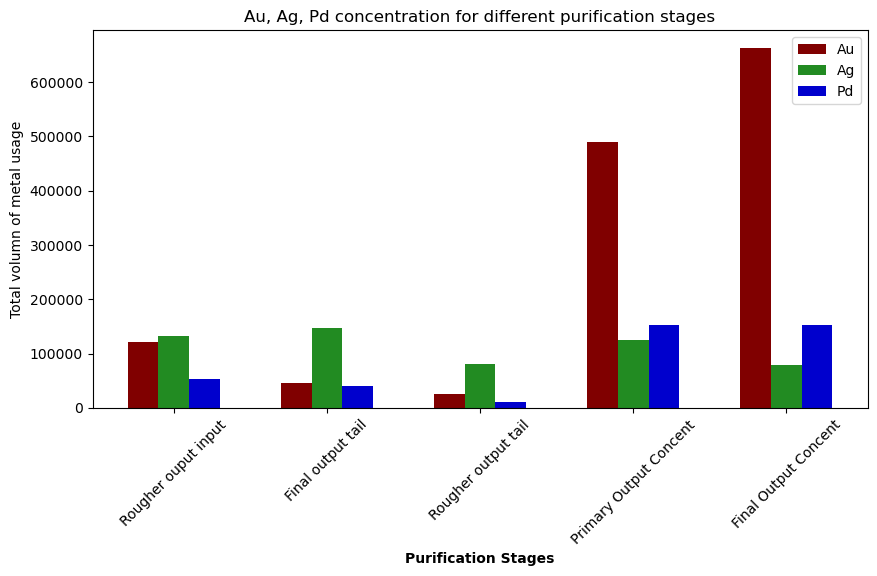

In [20]:
plot_1 = [au_rougher_input, au_final_tail,au_rougher_tail, au_primary_con, au_final_con]
plot_2 = [ag_rougher_input, ag_final_tail,ag_rougher_tail, ag_primary_con, ag_final_con]
plot_3= [pb_rougher_input, pb_final_tail,pb_rougher_tail, pb_primary_con, pb_final_con]

plt.figure(figsize=(10,5), dpi= 100)

barWidth = 0.2

z1 = np.arange(len(plot_1))
z2 = [x + barWidth for x in z1]
z3= [x + barWidth for x in z2]
plt.bar(z1, plot_1, color='#800000', width=barWidth,label = 'Au')
plt.bar(z2, plot_2, color='#228B22', width=barWidth,label = 'Ag')
plt.bar(z3, plot_3, color='#0000CD', width=barWidth,label = 'Pd')
plt.xticks(rotation = 45)    
plt.title('Au, Ag, Pd concentration for different purification stages')
plt.ylabel('Total volumn of metal usage')
plt.xlabel('Purification Stages',fontweight = 'bold')
plt.xticks([r + barWidth for r in range(len(plot_1))],
           ['Rougher ouput input', 'Final output tail', 'Rougher output tail','Primary Output Concent', 'Final Output Concent'])
 
plt.legend()
plt.show()

## Conclusion

The graph above shows the various purification stages and how the various metals are used. Au is the most used metal in the final stage.

## Compare the feed particle size distributions in the training set and in the test set. 

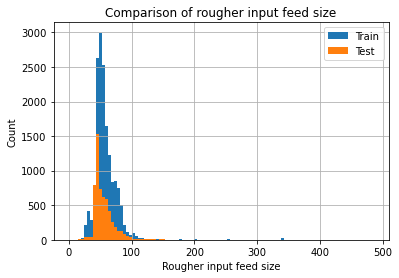

In [21]:
gold_train['rougher.input.feed_size'].hist(bins=100,label='Train')
gold_test['rougher.input.feed_size'].hist(bins=100,label='Test')
plt.xlim=(0,200)
plt.legend()
plt.title('Comparison of rougher input feed size')
plt.xlabel('Rougher input feed size')
plt.ylabel('Count');

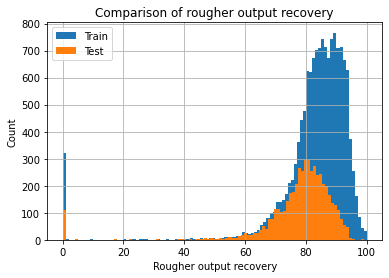

In [22]:
gold_train['rougher.output.recovery'].hist(bins=100,label='Train')
gold_test['rougher.output.recovery'].hist(bins=100,label='Test')
plt.xlim=(0,100)
plt.legend()
plt.title('Comparison of rougher output recovery')
plt.xlabel('Rougher output recovery')
plt.ylabel('Count');

In [23]:
display(gold_train['rougher.output.recovery'].describe())
gold_test['rougher.output.recovery'].describe()

count    14287.000000
mean        82.393959
std         15.096820
min          0.000000
25%         79.818375
50%         85.236000
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

count    5026.000000
mean       77.360588
std        14.617539
min         0.000000
25%        74.577278
50%        80.105629
75%        84.754669
max        99.132729
Name: rougher.output.recovery, dtype: float64

## Conclusion 
The distribution of both the training and test set seems to be the same.

<div class="alert alert-success">
<b>Reviewer's comment:</b> üëç
</div>


## Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 

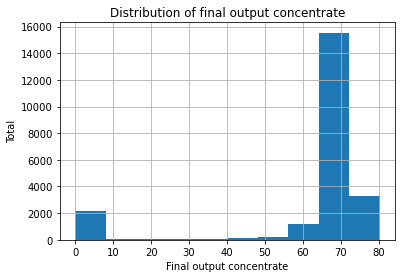

In [24]:
final_concentrate = col_str(gold_full,'final.output.concentrate')
final_concentrate.sum(1).hist()
plt.title('Distribution of final output concentrate')
plt.xlabel('Final output concentrate')
plt.ylabel('Total');

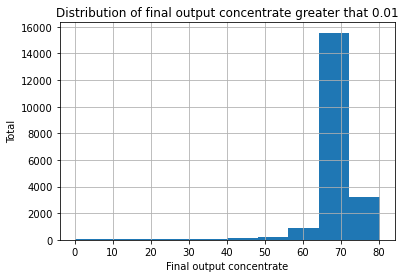

In [25]:
final_concentrate[final_concentrate >0.01].dropna().sum(1).hist()
plt.title('Distribution of final output concentrate greater that 0.01')
plt.xlabel('Final output concentrate')
plt.ylabel('Total');

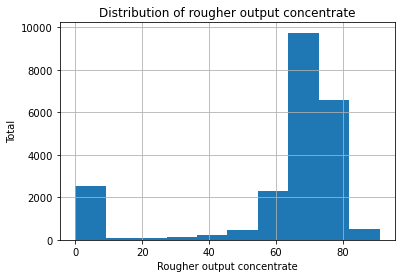

In [26]:
rougher_concentrate = col_str(gold_full,'rougher.output.concentrate')
rougher_concentrate.sum(1).hist()
plt.title('Distribution of rougher output concentrate')
plt.xlabel('Rougher output concentrate')
plt.ylabel('Total');

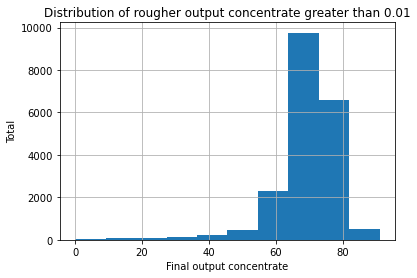

In [27]:
rougher_concentrate[rougher_concentrate >0.01].dropna().sum(1).hist()
plt.title('Distribution of rougher output concentrate greater than 0.01')
plt.xlabel('Final output concentrate')
plt.ylabel('Total');

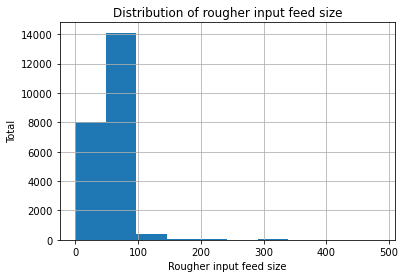

In [28]:
rougher_feed = col_str(gold_full,'rougher.input.feed_size')
rougher_feed.sum(1).hist()
plt.title('Distribution of rougher input feed size')
plt.xlabel('Rougher input feed size')
plt.ylabel('Total');

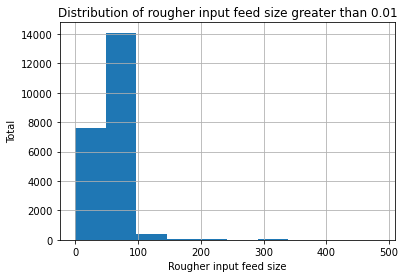

In [29]:
rougher_feed[rougher_feed >0.01].dropna().sum(1).hist()
plt.title('Distribution of rougher input feed size greater than 0.01')
plt.xlabel('Rougher input feed size')
plt.ylabel('Total');

## Conclusion 

The distribution are similar for raw feed, rougher concentrate and final concentrate with and without the null and values close to zero.

# Build the model

## Write a function to calculate the final sMAPE value.

In [30]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(gold_train.columns).intersection(set(gold_test.columns)).difference(set(target)))
features.remove('date')

gold_train = gold_train.dropna()
gold_test = gold_test.dropna()

In [31]:
smape_score = make_scorer(smape_final)

## Conclusion

The features for the model prediction have been limited to only columns available in the test set. 

## Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. 

In [32]:
x_train,x_test = gold_train[features].values,gold_test[features].values
y_train, y_test = gold_train[target].values,gold_test[target].values

In [33]:
liner_reg(x_train, x_test,y_train, y_test)

Mean smape: 0.06507914764806629
Smape: [0.02321793 0.11213129 0.04901175 0.03693783 0.10409694]


In [34]:
DecisionTreeReg(x_train, x_test,y_train, y_test)

Mean smape: 0.056626618441367904
Accuracy: 0.017444649041517313
Smape: [0.02326395 0.12273152 0.03072686 0.06567546 0.0407353 ]
Best params: {'max_depth': 6, 'min_samples_split': 2}


In [35]:
RandomForestReg(x_train, x_test,y_train, y_test)

Mean smape: 0.06975699628976066
Accuracy: 0.014203581843944654
Smape: [0.09221884 0.11827127 0.03416641 0.06109555 0.04303292]
Best params: {'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 41}


In [36]:
dm = DummyRegressor(strategy='mean').fit(x_train,y_train)
score_dm= cross_val_score(dm, x_train, y_train, cv=5, scoring=smape_score)
print('Mean smape:',score_dm.mean())
print('Accuracy',dm.score(x_test,y_test))

Mean smape: 0.07833194825798273
Accuracy -0.0985932970320984


## Conclusion 
Linear Regression smape: **0.065**

Decision Tree Regressor smape: **0.057**

Random Forest Regresor smape: **0.073**

Dummy Regressor smape: **0.078**

On average, the model giving the least error from its predicted values is Decision Tree Regressor. 


<div class="alert alert-success">
<b>Reviewer's comment:</b>  üëç
</div>


# Final Conclusion
**Preprocessing and Analysis**
The data columns of all datasets were converted from string to datetime and missing values of the date with forward filled based on the parameters set by Zyfra. Missing columns were dropped in the cause of the data usage whiles rougher.output.recovery and final.output.recovery which was not part of the test dataset were added. 

**Findings**
1. The most used metal is au at the final output concentrate stage of mineral processing.
2. The best result with least error rate of 0.057 was Decision Tree Regressor with an accuracy score of 0.017.